In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor/P_665_SP_.jpg
/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor/P_476_HF_.jpg
/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor/P_638_SP_.jpg
/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor/P_121_DA_.jpg
/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor/P_175_DA_.jpg
/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor/P_843_BR_.jpg
/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor/P_594_VF_.jpg
/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor/P_343.jpg
/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor/P_290_HF_.jpg
/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor/P_838_BR_.jpg
/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor/P_577_DA_.jpg
/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor/P_369_RO_.jpg
/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor/P_527_SP_.jpg
/kaggle/input/br

# A Clean Brain Tumor Dataset for Advanced Medical Research:

This dataset is taken from https://www.kaggle.com/datasets/mohammadhossein77/brain-tumors-dataset/data . It consists of four classes, including three tumor classes (Pituitary, Glioma and Meningioma) and there is another class which represents normal brain MRI scans. I have taken help from this code, https://www.kaggle.com/code/banddaniel/mri-classification-86-275-test-acc

# Importing Libraries

In [3]:
import tensorflow as tf
import random

import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



tf.config.run_functions_eagerly(True)
from tensorflow.keras.layers import Dense, Dropout, Input,Conv2D,Flatten, Conv1D, GlobalAveragePooling2D,MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.utils import shuffle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
batch_size = 32
image_size = 224
epochs = 10

# Creating main dataframe

In [6]:
# Creating main dataframe contains image paths and their classes

def create_images_list(path):
    data = []
    images = os.listdir(path)
    for i in tqdm(images, desc='images'):
        data.append(os.path.join(path, i))
        
    return data
    
data_normal = create_images_list('/kaggle/input/brain-tumors-dataset/Data/Normal')
data_glioma = create_images_list('/kaggle/input/brain-tumors-dataset/Data/Tumor/glioma_tumor')
data_meningioma = create_images_list('/kaggle/input/brain-tumors-dataset/Data/Tumor/meningioma_tumor')
data_pituitary = create_images_list('/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor')


# look-up table
tumor_classes = {0:'normal',
                1 : 'glioma',
                2 : 'meningioma',
                3 : 'pituitary'}


train_df = pd.concat([pd.DataFrame({"img": np.array(data_normal), "class": 0}),
                      pd.DataFrame({"img": np.array(data_glioma), "class":1}),
                      pd.DataFrame({"img": np.array(data_meningioma), "class":2}),
                      pd.DataFrame({"img": np.array(data_pituitary), "class":3}),
                     ], ignore_index = True)


train_df = shuffle(train_df).reset_index().drop(columns=['index'])
train_df.head()

images:   0%|          | 0/3066 [00:00<?, ?it/s]

images:   0%|          | 0/6307 [00:00<?, ?it/s]

images:   0%|          | 0/6391 [00:00<?, ?it/s]

images:   0%|          | 0/5908 [00:00<?, ?it/s]

,img,class
0,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,1
1,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,1
2,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,2
3,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,1
4,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,2


# Data Preprocessing

In [7]:
# Splitting dataset into train(80%) and test(20%).
X_train_, X_test, y_train_, y_test = train_test_split(train_df['img'], train_df['class'], test_size=0.2, shuffle=True)

X_train = X_train_[3500:]
X_val = X_train_[:3500]

y_train_ = tf.keras.utils.to_categorical(y_train_)

y_train = y_train_[3500:]
y_val = y_train_[:3500]
y_test = tf.keras.utils.to_categorical(y_test)

print("X_train shape -> ", X_train.shape)
print("X_val shape -> ", X_val.shape)
print("X_test shape -> ", X_test.shape)

X_train shape ->  (13837,)
X_val shape ->  (3500,)
X_test shape ->  (4335,)


In [8]:
# Creating preprocessing function for dataset loader

def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, size=(150, 150))
    img = img / 255.0
    return img, label

In [9]:
# dataset loaders
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (train_loader.map(img_preprocessing).batch(32).shuffle(X_train.shape[0]).prefetch(32))

validation_loader = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation_dataset = (validation_loader.map(img_preprocessing).batch(32).shuffle(X_val.shape[0]).prefetch(32))

test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (test_loader.map(img_preprocessing).batch(32).shuffle(X_test.shape[0]).prefetch(32))


# Model MobileNetV2

In [10]:
# Using MobileNetV2 for transfer learning
base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
# Model MobileNetV2
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

# CNN Model

In [12]:
In = Input(shape=(150,150,1))

conv1 = Conv2D(32, (3,3), padding = 'same' , activation = 'relu')(In)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.1)(conv1)

conv2 = Conv2D(128, (3,3) , padding = 'same', activation = 'relu')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.1)(conv2)

pool = GlobalAveragePooling2D()(conv2)

dense1 = Dense(64, activation = 'relu')(pool)
Out = Dense(4, activation = 'softmax')(dense1)

model = Model(inputs = In, outputs = Out)



In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 150, 150, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 128)     36992     
                                                                 
 batch_normalization_1 (Bat  (None, 150, 150, 128)     512       
 chNormalization)                                            

In [14]:
history = model.fit(train_dataset, epochs=10, batch_size=32,
                 verbose=1, validation_data=validation_dataset,
                 callbacks=[ModelCheckpoint('New_Model.h5', save_best_only=True, monitor='val_accuracy'),
                            EarlyStopping(patience=15, monitor='val_auc')])

Epoch 1/10
433/433 [==============================] - 131s 232ms/step - loss: 1.0563 - accuracy: 0.5441 - auc: 0.7874 - val_loss: 2.4930 - val_accuracy: 0.2683 - val_auc: 0.6838
Epoch 2/10
433/433 [==============================] - 106s 227ms/step - loss: 0.9348 - accuracy: 0.6043 - auc: 0.8348 - val_loss: 1.2617 - val_accuracy: 0.4763 - val_auc: 0.8000
Epoch 3/10
433/433 [==============================] - 104s 223ms/step - loss: 0.8758 - accuracy: 0.6300 - auc: 0.8552 - val_loss: 0.8984 - val_accuracy: 0.6223 - val_auc: 0.8673
Epoch 4/10
433/433 [==============================] - 103s 221ms/step - loss: 0.8238 - accuracy: 0.6556 - auc: 0.8724 - val_loss: 0.9560 - val_accuracy: 0.5974 - val_auc: 0.8525
Epoch 5/10
433/433 [==============================] - 103s 221ms/step - loss: 0.7851 - accuracy: 0.6741 - auc: 0.8836 - val_loss: 1.0724 - val_accuracy: 0.5571 - val_auc: 0.8658
Epoch 6/10
433/433 [==============================] - 102s 221ms/step - loss: 0.7447 - accuracy: 0.6922 - auc:

In [20]:
evaluation_test = model.evaluate(test_dataset)
print('Test accuracy:{0:.2f} %'.format(evaluation_test[1] * 100))

136/136 [==============================] - 19s 122ms/step - loss: 0.6726 - accuracy: 0.7174 - auc: 0.9229
Test accuracy:71.74 %


# Visualizing the training history:
(like loss and accuracy over epochs)

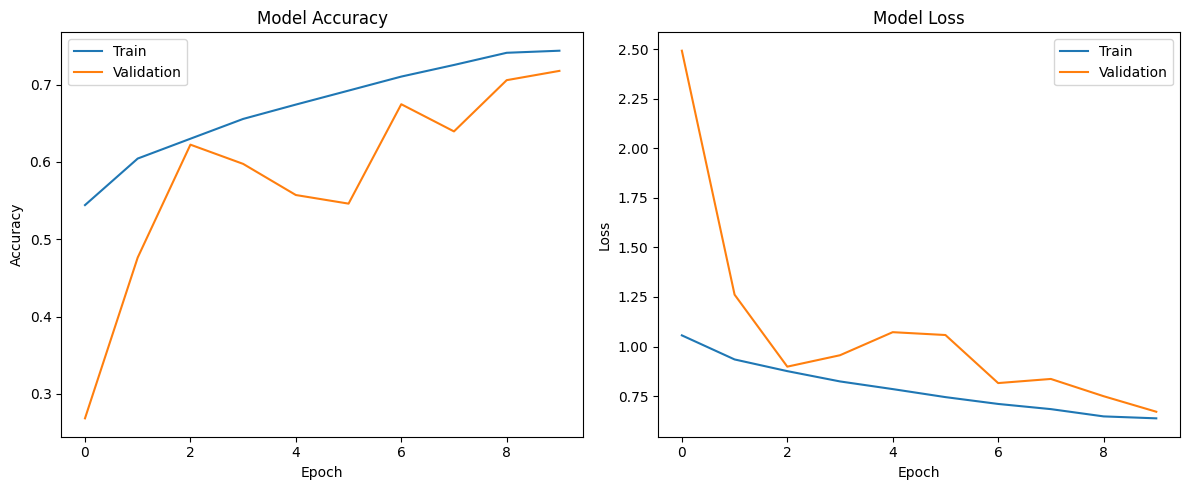

In [16]:
import matplotlib.pyplot as plt

# Plotting training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Visualizing Sample Predictions:
Sample predictions can be beneficial to understand the model's performance.

136/136 [==============================] - 5s 18ms/step


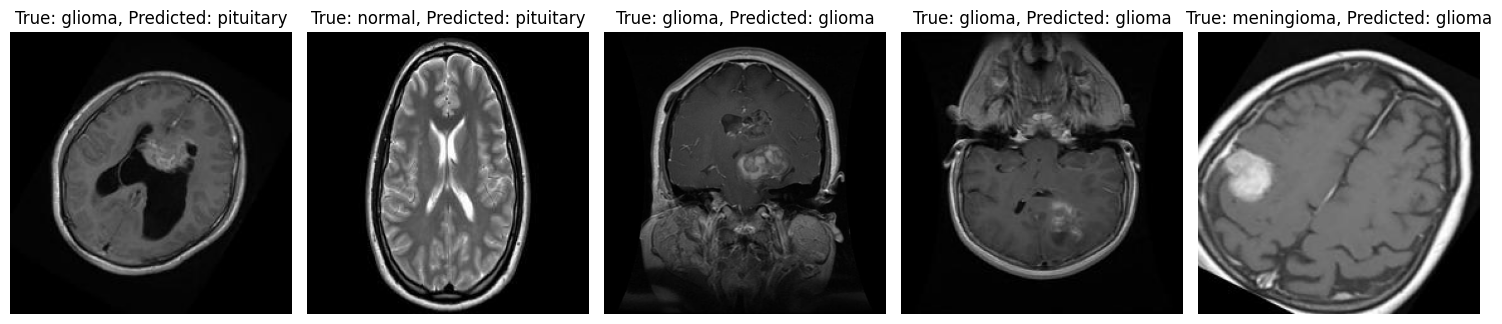

In [18]:
# for making predictions and visualizing sample predictions
from skimage import io


# Making predictions on test dataset
predictions = model.predict(test_dataset)

# Selecting random samples for visualization
num_samples = 5
sample_indices = np.random.choice(len(predictions), num_samples, replace=False)

# Visualizing sample predictions
plt.figure(figsize=(15, 7))
for i, index in enumerate(sample_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(io.imread(X_test.iloc[index]))
    plt.title(f"True: {tumor_classes[np.argmax(y_test[index])]}, Predicted: {tumor_classes[np.argmax(predictions[index])]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
